# Stability test

## Interferometer chamber

### Under air
The following measurements were done under air but the lids of the chamber were on and all the laser path was covered by some plastic tube or the chamber itself. 

Results on the measurements on 04/10/2019:

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import pandas as pd
from tqdm import tqdm
import scipy.constants as cns

In [6]:
path = 'O:\\19_LaserData\\14_LTA1\\Automatic_recordings\\data\\frames'
fname = os.listdir(path)

In [7]:
fname.pop(1)

'phases_20191004_133111.h5'

We drop the second measurements because there were big phase jumps on that. 

In [8]:
def read_h5file(name):
    with h5py.File(name, 'r') as f:
        ph = np.array(f['phase'])
        ti = np.array(f['time'])
        #raw = np.array(f['signal'])
    return (ti, ph)

def normalize_time(t):
    t = t - t.min()
    tmp = np.linspace(0, np.round(t.max()), len(t))
    return(tmp)


In [61]:
exp = []
for i,fn in tqdm(enumerate(fname)):
    fullname = os.path.join(path, fn)
    ti, ph = read_h5file(fullname)
    df = pd.DataFrame({'time':ti, 'phase':ph}, index=normalize_time(ti))
    exp.append(df)


3it [00:00, 17.30it/s]


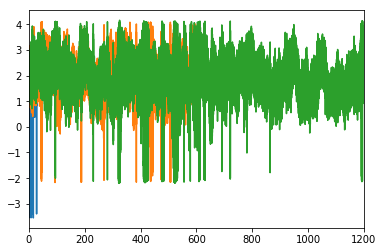

In [62]:
for i in exp:
    i['phase'].plot()

In [63]:
exp_mod=[]
for m in exp:
    tmp = m.copy()
    tmp=tmp.drop(columns=['time'])
    tmp.phase = tmp.phase - tmp.phase.mean()
    tmp['20p_std'] = tmp.phase.rolling(20, center=True).std()
    tmp['std'] = tmp.phase.std()
    exp_mod.append(tmp)

Lets print out the standard deviation of the different measurements.

In [64]:
std=[]
for i in exp_mod:
    print(i.loc[0,'std'])
    std.append(i.loc[0,'std'])

0.47181366000030045
0.6601686788172011
0.7107195155120869


In [65]:
np.mean(std)

0.6142339514431961

This result tells us that the average standard deviation over the different measurements is 0.61 rad. But this includes the random door closures that causes big noise. Lets investigate instead the distribution of the noise.

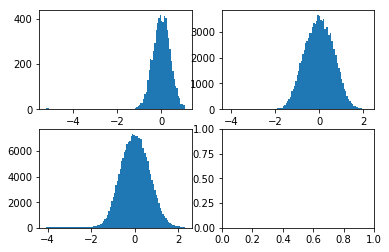

In [66]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=2)
for j, i in enumerate(exp_mod):
    plt.subplot(2, 2, j+1)
    plt.hist(i[['phase']].values,bins=100)

It is easy to see that any data that is basically outside the -2..2 radian range is an artificial noise that is caused by a door or somebody dancing in the lab. To get a better estimate on the standard deviation we will not focus on the tail events. 

In [67]:
exp_filtered=[]
for m in exp_mod:
    tmp = m.copy()
    tmp.phase[(tmp['phase'] < -2)] = 0
    tmp.phase[(tmp['phase'] > 2)] = 0
    tmp['20p_std'] = tmp.phase.rolling(20, center=True).std()
    tmp['std'] = tmp.phase.std()
    exp_filtered.append(tmp)

In [68]:
std=[]
for i in exp_filtered:
    print(i.loc[0,'std'])
    std.append(i.loc[0,'std'])

0.38397796134297657
0.6394999047074225
0.6390220441156537


In [69]:
std_mean=np.mean(std)

The average distance from the mean is $\pm$0.55 radians. Therefore it corresponds to a phase shift of $\Delta\phi$=1.1rad. Assuming a diode laser wavelength $\lambda$=530 nm, the phase shift corresponds to:

In [70]:
lbd = 530e-9
dphi=2*std_mean
dx = dphi*lbd / (2*np.pi)
print(dx*1e9, 'nm')

93.49026110277494 nm


This distance is done twice by the light on the interferometer so the temporal stability of the given interferometer is:

In [71]:
dt = 2*dx/cns.c
print(dt*1e18, 'as')

623.6998870917222 as


### Spectral analysis

In [76]:
exp_fft=[]
for m in exp_mod:
    N = len(m.phase)
    t = m.index.values
    T = t.max() - t.min()
    dw = 2*np.pi / T
    dNu = 1 / (t[1]-t[0])
    print(dNu)
    freq = np.fft.fftshift(np.fft.fftfreq(N) * N * dw) / 2 / np.pi
    yft = np.fft.fftshift(np.fft.fft(m.phase))
    yft_hamming = np.fft.fftshift(np.fft.fft(m.phase * np.hamming(N)))
    tmp = pd.DataFrame({'fft':yft, 'fft_hmg':yft_hamming, 'spectrum':np.abs(yft_hamming)/np.max(np.abs(yft_hamming))}, index=freq)
    tmp['sp_smooth'] = tmp[['spectrum']].rolling(20, win_type='hamming', center=True).mean()
    exp_fft.append(tmp)

218.79999999999998
161.80833333333334
162.915


(0, 0.1)

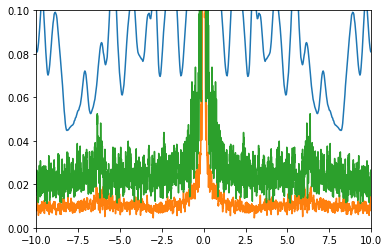

In [79]:
for i in exp_fft:
    i['sp_smooth'].plot()
plt.xlim([-10, 10])
plt.ylim([0,0.1])